In [7]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
%matplotlib inline
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

--2024-04-22 18:44:01--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.002s  

2024-04-22 18:44:01 (13.0 MB/s) - ‘original.png’ saved [34146/34146]



## Preprocessing Image

In [5]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

## Saving Image

In [6]:
def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [8]:
def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

## Super Resolution Process

Saved as Original Image.jpg
Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

Time Taken: 6.194567
Saved as Super Resolution.jpg


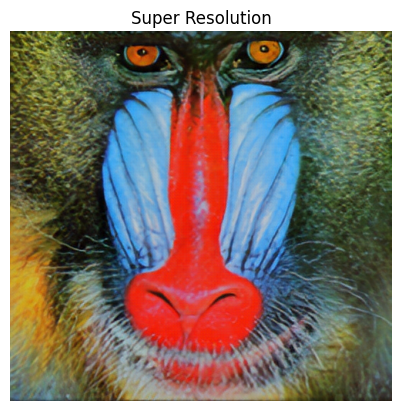

In [9]:
hr_image = preprocess_image(IMAGE_PATH)
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")
model = hub.load(SAVED_MODEL_PATH)
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [16]:
saved_model_path = "saved_model_super_resolution"
tf.saved_model.save(model, saved_model_path)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model_super_resolution = converter.convert()
with open("model_super_resolution.tflite", "wb") as f:
    f.write(tflite_model_super_resolution)

In [10]:
IMAGE_PATH="/content/testing.jpg"

In [11]:
def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

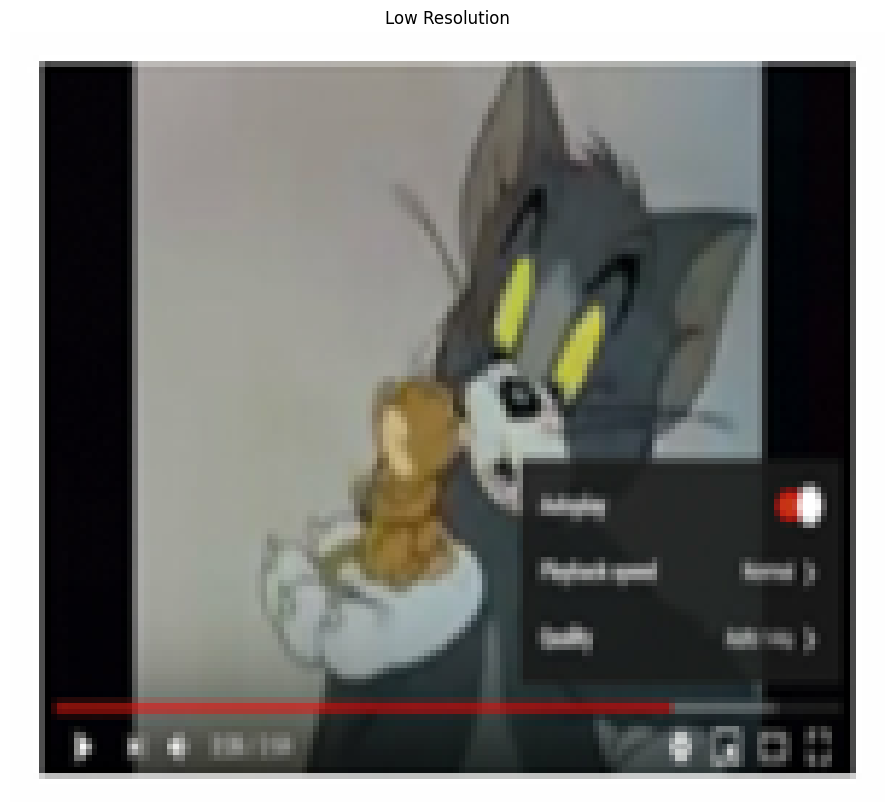

In [18]:
hr_image = preprocess_image(IMAGE_PATH)
lr_image = downscale_image(tf.squeeze(hr_image))
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")
saved_model_path_low_resolution = "saved_model_low_resolution"
tf.saved_model.save(model, saved_model_path_low_resolution)
converter_low_resolution = tf.lite.TFLiteConverter.from_saved_model(saved_model_path_low_resolution)
tflite_model_low_resolution = converter_low_resolution.convert()
with open("model_low_resolution.tflite", "wb") as f:
    f.write(tflite_model_low_resolution)

In [13]:
  model = hub.load(SAVED_MODEL_PATH)

Time Taken: 10.943294
PSNR Achieved: 30.963049


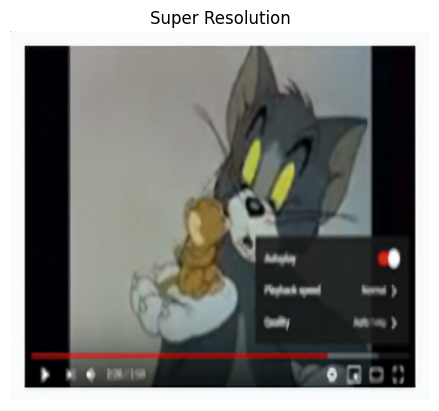

In [14]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

## COMPARING LOW VS SUPER RESOLUTION

PSNR: 30.963049


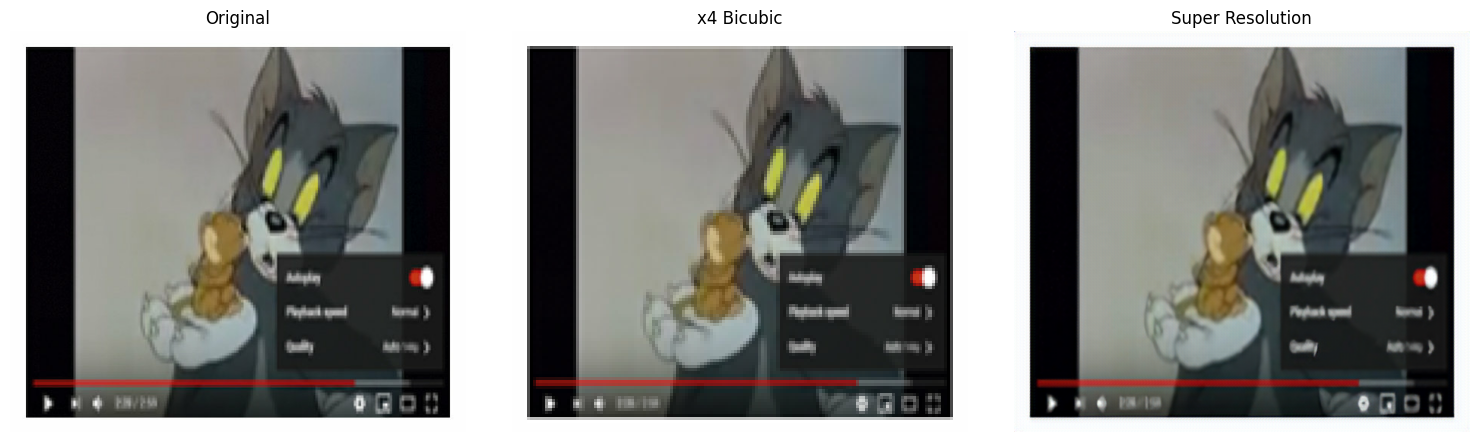

In [15]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)